<a href="https://colab.research.google.com/github/AssumptionXiaohan/data-explore/blob/master/Wildfire_Version1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [0]:
#Split train test data
dir =  '/Users/casey/caseyzzz/data-explore/Caseyzzz/'
import os
os.chdir (dir)
torch.set_default_dtype(torch.double)

# Better Data
## - More data:
1. add all 25 channels

2. Fire: No_Fire = 1:5

3. More Fire Data

4. flip + rotate

5. Label into two column(Fire, No-Fire)

## - Preprocessing:
1. Nomarlization -> Visualize and then find better way to normalize

2. Null -> 0, negative -> 0 


# Better Model
## - Change Plan
1. one more fc and conv

2. Kernal size change

3. Adam as optimizer

4. visualize the weigth to analyze the model

5. ensitivity

## - Change Log
1. training time from 10 -> 200


In [0]:
#Preprocessing null and negative data into 0
#Count null value for pixel
def na_negative_data(trainset):
    for i in range(len(trainset)):
        feature=trainset.iloc[i,:-1]
        for j in range(len(feature)):
            if pd.isna(feature[j]):
                feature[j] = 0
            if feature[j] < 0:
                feature[j] = 0
    return trainset

In [0]:
#Train Test Split
from sklearn.model_selection import train_test_split
ds = pd.read_csv('dataset.csv',header=None)
train, test = train_test_split(ds, test_size = 0.2,random_state=42)

train = na_negative_data(train)
test = na_negative_data(test)

#label = train.iloc[:,-1]
#temp0 = 1-label
#train.insert(train.shape[1],'385',temp0)

#t_label = test.iloc[:,-1]
#temp1 = 1-t_label
#test.insert(test.shape[1],'385',temp1)

train.to_csv('train.csv', index = None,header = None)
test.to_csv('test.csv',index = None,header = None)

In [0]:
df0 = pd.read_csv('train.csv',header = None)
df0.describe()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,384
count,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,...,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000
mean,1.188445,1.229821,1.260499,1.287377,1.307751,1.329772,1.354190,1.377502,1.213132,1.238609,...,4.472125,4.175958,4.175958,4.264808,4.235192,4.353659,4.383275,4.442509,4.531359,0.329965
std,7.346568,7.574832,7.770183,7.927579,8.050399,8.206731,8.364756,8.481319,7.499417,7.628592,...,33.474202,32.365914,32.365914,32.702626,32.590802,33.035668,33.145885,33.365148,33.691173,0.470227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


In [0]:
from torch.utils.data import DataLoader, Dataset

class WildfireDataset(Dataset):
    """Wildfire Preset 1 dataset."""
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path,header = None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index,:-1].to_numpy().reshape((6, 8, 8))
        label = self.data.iloc[index,-1]
        
        if self.transform is not None:
            feature = self.transform(image)
        return image, label

In [0]:
#initialize dataset class
train_dataset = WildfireDataset('train.csv', transform=torch.from_numpy)

In [0]:
#load train_data
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [0]:
train_iter = iter(train_loader)
print(type(train_iter))
images, labels = train_iter.next()
print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))
print(type(images))
print(images.dtype)
print(type(labels))
print(labels.dtype)

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([4, 6, 8, 8])
labels shape on batch size = torch.Size([4])
<class 'torch.Tensor'>
torch.float64
<class 'torch.Tensor'>
torch.float64


In [0]:
# CIFAR Model for Wildfire
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 1)
        #self.conv2 = nn.Conv2d(32, 64, 2)
        self.conv3 = nn.Conv2d(64, 128, 1)
        self.fc1 = nn.Linear(128 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
'''
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x
'''
net = Net()
net = net.double()

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#adam

In [0]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.type(torch.double)
        inputs = inputs.type(torch.double) 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).type(torch.double) 
        loss = criterion(outputs, labels.type(torch.long))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.615
[2,  2000] loss: 0.589
[3,  2000] loss: 0.582
[4,  2000] loss: 0.578
[5,  2000] loss: 0.576
[6,  2000] loss: 0.570
[7,  2000] loss: 0.568
[8,  2000] loss: 0.566
[9,  2000] loss: 0.564
[10,  2000] loss: 0.562
Finished Training


In [0]:
#save our trained model:
PATH = 'wildfire_preset1.pth'
torch.save(net.state_dict(), PATH)

In [0]:
#load back in our saved model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
train_iter = iter(train_loader)
sample = train_iter.next()
image, label = sample 
print(image.shape)
pred = net(image) # image shape needs to be (batch_size × in_channels × H × W)
print('the prediction tensor',pred)
print('the prediction shape',pred.shape)
print('the label',label)
print('The probability of firing', F.softmax(pred, dim=1))

torch.Size([4, 6, 8, 8])
the prediction tensor tensor([[ 1.7595, -1.4062],
        [ 0.3250, -0.0657],
        [ 0.9495, -1.5271],
        [ 0.3185, -0.1702]], grad_fn=<AddmmBackward>)
the prediction shape torch.Size([4, 2])
the label tensor([0., 0., 0., 0.])
The probability of firing tensor([[0.9595, 0.0405],
        [0.5965, 0.4035],
        [0.9225, 0.0775],
        [0.6198, 0.3802]], grad_fn=<SoftmaxBackward>)


In [0]:
def classifier(predicted):
    result = torch.zeros(4, 2).type(torch.int)
    j = 0
    for i in predicted:
        if i.data[0] > i.data[1]:
            result.data[j, 0] = 1
            result.data[j, 1] = 0
        else:
            result.data[j, 0] = 0
            result.data[j, 1] = 1
        j+=1
    return result

In [0]:
test_dataset = WildfireDataset('test.csv', transform=torch.from_numpy)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 66 %


In [0]:
classes = ('fire', 'no fire')

In [0]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if list(c.size()) ==[4]:
            for i in range(4):
                label = labels[i].type(torch.int)
                class_correct[label] += c[i].item()
                class_total[label] += 1
        else:
            label = labels.type(torch.int)
            class_correct[label] += c.item()
            class_total[label] += 1
            
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  fire : 95 %
Accuracy of no fire : 12 %


In [0]:
with torch.no_grad():
    prob_list=[]
    for data in testloader:
        images, labels = data
        outputs = net(images)
        predicted = F.softmax(outputs, dim=1)
        fire_prob = predicted[:,0].numpy()*100
        for i in range(len(fire_prob)):
            prob_list.append(fire_prob[i])

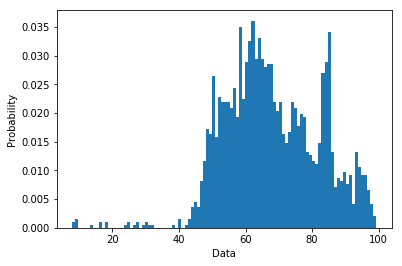

In [0]:
import matplotlib.pyplot as plt
plt.hist(prob_list, density=True, bins=100)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Probaility')

In [0]:
#define device as the first visible cuda device if CUDA available:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.